In [2]:
import pickle

In [3]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("kabir- suggestion-things")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1718884210833, experiment_id='2', last_update_time=1718884210833, lifecycle_stage='active', name='kabir- suggestion-things', tags={}>

In [7]:
pd.__version__

'2.2.2'

In [8]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [9]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_3111/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_3111/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


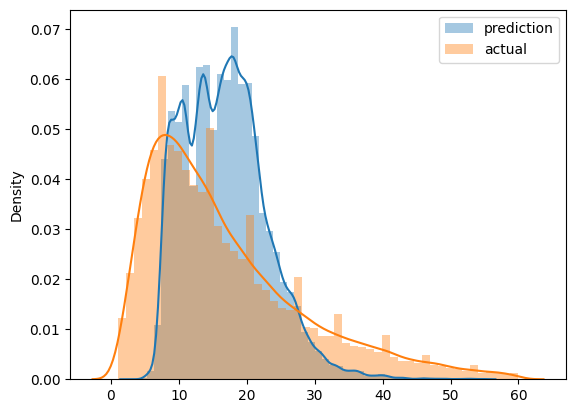

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:

df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [14]:

len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)


In [20]:
with mlflow.start_run():

    mlflow.set_tag("developer", "remilekun")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [22]:
import xgboost as xgb

In [23]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [24]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [25]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [33]:
def objective(params):
    with mlflow.start_run():

         # Log model type as a tag
        mlflow.set_tag("model", "xgboost")

         # Log hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

         # Description and developer information 
        mlflow.set_tag("description", 'this is the information about xgboost training')
        mlflow.set_tag("developer", 'usman ibrahim')
        
         # XGBoost training with model logging
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=50,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
       
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [34]:
# Hyperparameter search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 234
}

# Hyperparameter optimization with MLflow logging

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

[0]	validation-rmse:11.74591                          
[1]	validation-rmse:11.31519                          
[2]	validation-rmse:10.91819                          
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:32:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.55254                          
[4]	validation-rmse:10.21722                          
[5]	validation-rmse:9.90910                           
[6]	validation-rmse:9.62655                           
[7]	validation-rmse:9.36892                           
[8]	validation-rmse:9.13283                           
[9]	validation-rmse:8.91770                           
[10]	validation-rmse:8.72154                          
[11]	validation-rmse:8.54247                          
[12]	validation-rmse:8.37984                          
[13]	validation-rmse:8.23312                          
[14]	validation-rmse:8.09905                          
[15]	validation-rmse:7.97729                          
[16]	validation-rmse:7.86767                          
[17]	validation-rmse:7.76771                          
[18]	validation-rmse:7.67664                          
[19]	validation-rmse:7.59512                          
[20]	validation-rmse:7.52086                          
[21]	valid

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.59607                                                  
[1]	validation-rmse:11.04217                                                  
 10%|█         | 1/10 [00:04<00:36,  4.10s/trial, best loss: 6.83666949522307]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:32:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.54746                                                  
[3]	validation-rmse:10.10451                                                  
[4]	validation-rmse:9.71135                                                   
[5]	validation-rmse:9.36248                                                   
[6]	validation-rmse:9.05221                                                   
[7]	validation-rmse:8.77796                                                   
[8]	validation-rmse:8.53615                                                   
[9]	validation-rmse:8.32293                                                   
[10]	validation-rmse:8.13560                                                  
[11]	validation-rmse:7.97098                                                  
[12]	validation-rmse:7.82674                                                  
[13]	validation-rmse:7.70113                                                  
[14]	validation-rmse:7.59081                        

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.72931                                                    
[1]	validation-rmse:9.62712                                                     
[2]	validation-rmse:8.82119                                                     
 20%|██        | 2/10 [00:08<00:32,  4.06s/trial, best loss: 6.7866317412666275]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:32:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.24416                                                     
[4]	validation-rmse:7.83228                                                     
[5]	validation-rmse:7.54266                                                     
[6]	validation-rmse:7.33536                                                     
[7]	validation-rmse:7.19207                                                     
[8]	validation-rmse:7.09244                                                     
[9]	validation-rmse:7.01967                                                     
[10]	validation-rmse:6.96839                                                    
[11]	validation-rmse:6.93007                                                    
[12]	validation-rmse:6.90157                                                    
[13]	validation-rmse:6.88024                                                    
[14]	validation-rmse:6.86268                                                    
[15]	validation-rmse:6.85098

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:32:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71102                                                   
[1]	validation-rmse:11.25005                                                   
[2]	validation-rmse:10.82756                                                   
[3]	validation-rmse:10.44133                                                   
[4]	validation-rmse:10.08880                                                   
[5]	validation-rmse:9.76661                                                    
[6]	validation-rmse:9.47410                                                    
[7]	validation-rmse:9.20754                                                    
[8]	validation-rmse:8.96631                                                    
[9]	validation-rmse:8.74716                                                    
[10]	validation-rmse:8.54879                                                   
[11]	validation-rmse:8.36906                                                   
[12]	validation-rmse:8.20688            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.69282                                                    
 40%|████      | 4/10 [00:19<00:31,  5.21s/trial, best loss: 6.7411060893219075]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.21629                                                    
[2]	validation-rmse:10.78219                                                    
[3]	validation-rmse:10.38579                                                    
[4]	validation-rmse:10.02506                                                    
[5]	validation-rmse:9.69824                                                     
[6]	validation-rmse:9.40108                                                     
[7]	validation-rmse:9.13287                                                     
[8]	validation-rmse:8.88972                                                     
[9]	validation-rmse:8.67097                                                     
[10]	validation-rmse:8.47370                                                    
[11]	validation-rmse:8.29613                                                    
[12]	validation-rmse:8.13624                                                    
[13]	validation-rmse:7.99280

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.51768                                                    
[1]	validation-rmse:9.31588                                                     
 50%|█████     | 5/10 [00:25<00:27,  5.56s/trial, best loss: 6.7411060893219075]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.48704                                                     
[3]	validation-rmse:7.92236                                                     
[4]	validation-rmse:7.54481                                                     
[5]	validation-rmse:7.29442                                                     
[6]	validation-rmse:7.12619                                                     
[7]	validation-rmse:7.01194                                                     
[8]	validation-rmse:6.93539                                                     
[9]	validation-rmse:6.88732                                                     
[10]	validation-rmse:6.85165                                                    
[11]	validation-rmse:6.82692                                                    
[12]	validation-rmse:6.80871                                                    
[13]	validation-rmse:6.79264                                                    
[14]	validation-rmse:6.78252

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.63423                                                    
[1]	validation-rmse:6.92852                                                    
 60%|██████    | 6/10 [00:29<00:20,  5.10s/trial, best loss: 6.717336490255115]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.81078                                                    
[3]	validation-rmse:6.77765                                                    
[4]	validation-rmse:6.76320                                                    
[5]	validation-rmse:6.75207                                                    
[6]	validation-rmse:6.74550                                                    
[7]	validation-rmse:6.74253                                                    
[8]	validation-rmse:6.73644                                                    
[9]	validation-rmse:6.72970                                                    
[10]	validation-rmse:6.72506                                                   
[11]	validation-rmse:6.71948                                                   
[12]	validation-rmse:6.71586                                                   
[13]	validation-rmse:6.71158                                                   
[14]	validation-rmse:6.70523            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:9.47425                                                    
 70%|███████   | 7/10 [00:33<00:13,  4.63s/trial, best loss: 6.615849042347663]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.06181                                                    
[2]	validation-rmse:7.37579                                                    
[3]	validation-rmse:7.05378                                                    
[4]	validation-rmse:6.89696                                                    
[5]	validation-rmse:6.81703                                                    
[6]	validation-rmse:6.77360                                                    
[7]	validation-rmse:6.74720                                                    
[8]	validation-rmse:6.72937                                                    
[9]	validation-rmse:6.71987                                                    
[10]	validation-rmse:6.71392                                                   
[11]	validation-rmse:6.71066                                                   
[12]	validation-rmse:6.70733                                                   
[13]	validation-rmse:6.70450            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.64248                                                   
 80%|████████  | 8/10 [00:37<00:08,  4.49s/trial, best loss: 6.615849042347663]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.12544                                                   
[2]	validation-rmse:10.65793                                                   
[3]	validation-rmse:10.23532                                                   
[4]	validation-rmse:9.85559                                                    
[5]	validation-rmse:9.51356                                                    
[6]	validation-rmse:9.20721                                                    
[7]	validation-rmse:8.93208                                                    
[8]	validation-rmse:8.68627                                                    
[9]	validation-rmse:8.46780                                                    
[10]	validation-rmse:8.27305                                                   
[11]	validation-rmse:8.10057                                                   
[12]	validation-rmse:7.94646                                                   
[13]	validation-rmse:7.80884            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:11.77940                                                   
 90%|█████████ | 9/10 [00:43<00:04,  4.89s/trial, best loss: 6.615849042347663]

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:33:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.37653                                                   
[2]	validation-rmse:11.00275                                                   
[3]	validation-rmse:10.65643                                                   
[4]	validation-rmse:10.33593                                                   
[5]	validation-rmse:10.03948                                                   
[6]	validation-rmse:9.76587                                                    
[7]	validation-rmse:9.51339                                                    
[8]	validation-rmse:9.28067                                                    
[9]	validation-rmse:9.06649                                                    
[10]	validation-rmse:8.86961                                                   
[11]	validation-rmse:8.68882                                                   
[12]	validation-rmse:8.52269                                                   
[13]	validation-rmse:8.37078            

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

